In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
%matplotlib inline

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Сценарий:

    - заранее выдвигаем шторку с фонариком и запускаем браузер
    - включаем мониторинг
    - мигаем фонариком пять раз
    - задвигаем шторку, ждем чуть больше минуты
    - жмем на загрузку файла, ждем окончания
    - ждем еще несколько секунд, стопаем мониторинг

Читаем данные из порта USB в файл:

`cat /dev/cu.usbmodem1421 > browser_download.bin`

Они будут в бинарном формате, прочитаем их в DataFrame и сконвертируем в миллиамперы:

In [2]:
df = pd.DataFrame(np.fromfile(
        "./browser_download_lte.bin",
        dtype=np.uint16).astype(np.float32) * (3300 / 2**12))

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.5/site-packages/matplotlib/colors.py:949: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.5/site-packages/matplotlib/colors.py:950: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/usr/local/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


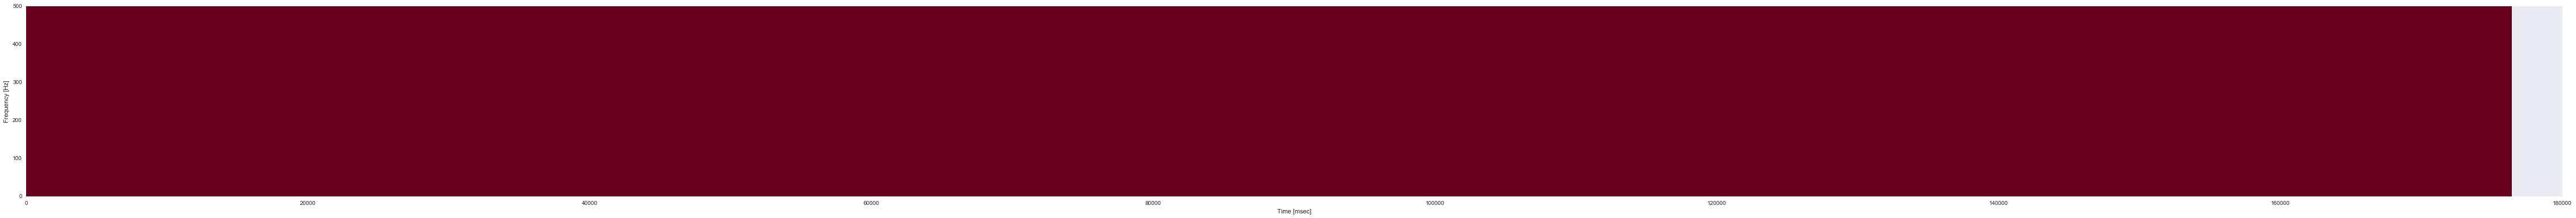

In [28]:
f, t, Sxx = signal.spectrogram(df[0], 1e3)
fig = sns.plt.figure(figsize=(80, 6))
ax = sns.plt.subplot()
sns.plt.pcolormesh(t, f, np.log(Sxx), cmap='RdBu')
sns.plt.ylabel('Frequency [Hz]')
sns.plt.xlabel('Time [msec]')
sns.plt.show()

Группируем по миллисекундам и усредняем:

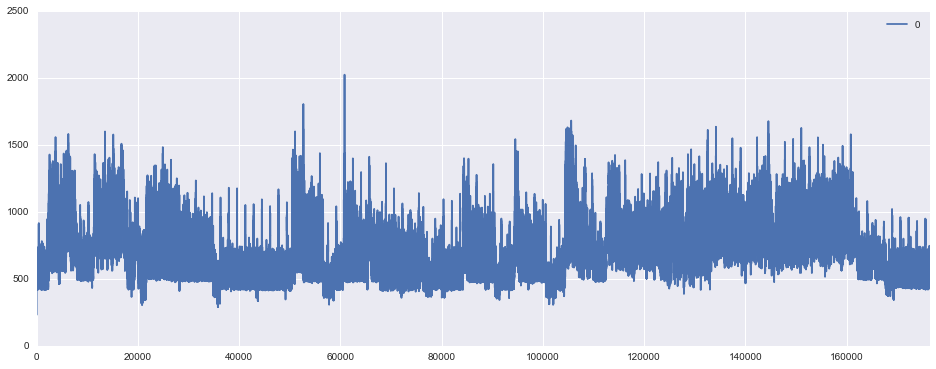

In [3]:
df_r1000 = df.groupby(df.index//1000).mean()
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df_r1000.plot(ax=ax)

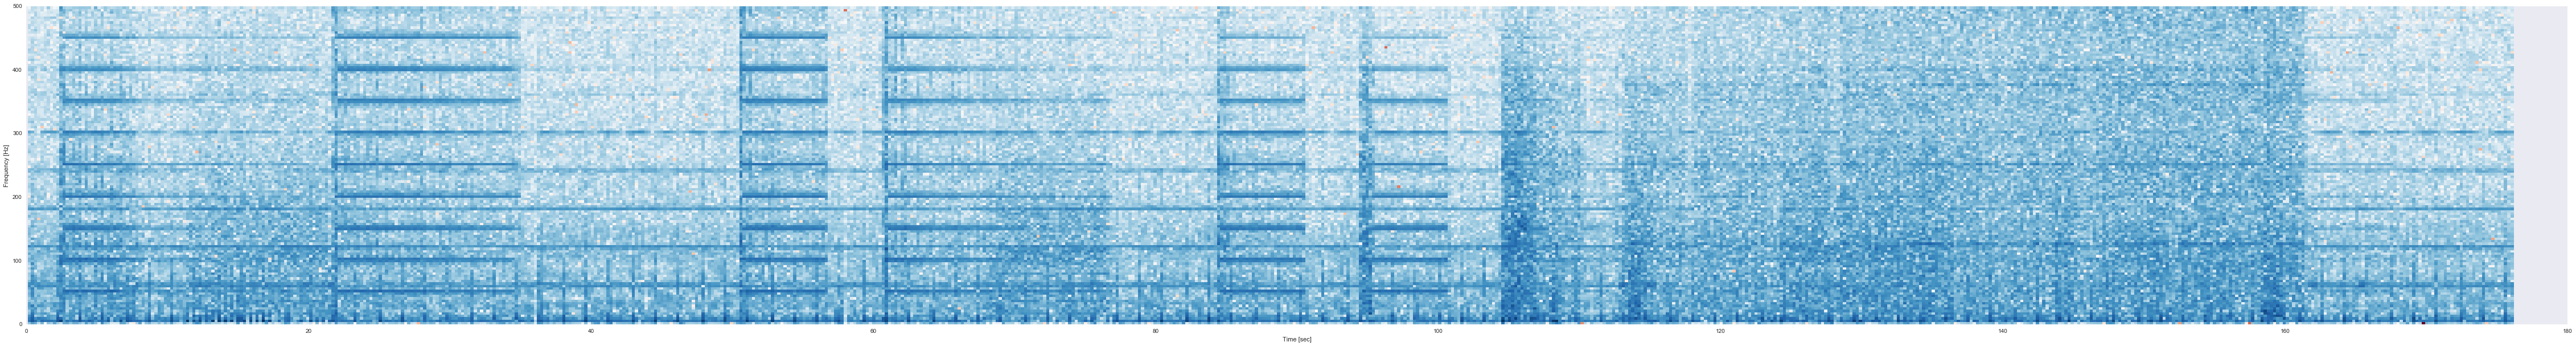

In [37]:
f, t, Sxx = signal.spectrogram(df_r1000[0], 1e3)
fig = sns.plt.figure(figsize=(80, 10))
ax = sns.plt.subplot()
sns.plt.pcolormesh(t, f, np.log(Sxx), cmap='RdBu')
sns.plt.ylabel('Frequency [Hz]')
sns.plt.xlabel('Time [sec]')
sns.plt.show()

In [5]:
df_r1000.to_csv("")

<bound method NDFrame.to_json of                  0
0       232.485641
1       436.257416
2       438.682465
3       480.576996
4       449.653198
5       525.780396
6       570.539062
7       567.307556
8       453.277069
9       441.714172
10      499.983826
11      437.313660
12      434.271454
13      490.971680
14      444.240753
15      463.343048
16      418.855896
17      436.313812
18      434.357666
19      439.796692
20      465.585999
21      466.013000
22      562.233459
23      560.467468
24      453.472839
25      435.380859
26      435.384888
27      434.476105
28      433.352997
29      437.410339
...            ...
176369  525.371094
176370  552.385864
176371  598.887146
176372  520.689392
176373  439.448669
176374  442.077545
176375  614.741821
176376  719.731934
176377  747.030273
176378  668.693909
176379  600.071472
176380  564.308838
176381  539.618469
176382  570.613159
176383  586.722412
176384  584.493164
176385  571.625122
176386  592.733521
176387  659.23785

Интересные нам всплески потребления начинаются в районе 10000-й и кончаются где-то на 20000-ной миллисекунде.

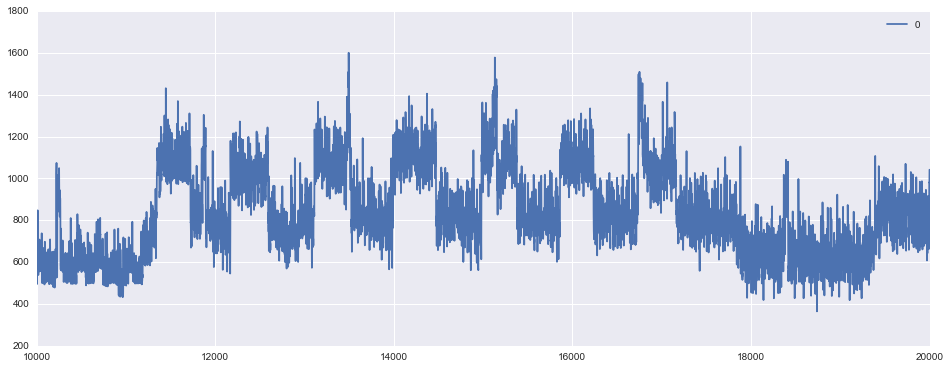

In [7]:
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df_r1000[10000:20000].plot(ax=ax)

Синхронизируемся по 2-му всплеску, кажется, он самый острый:

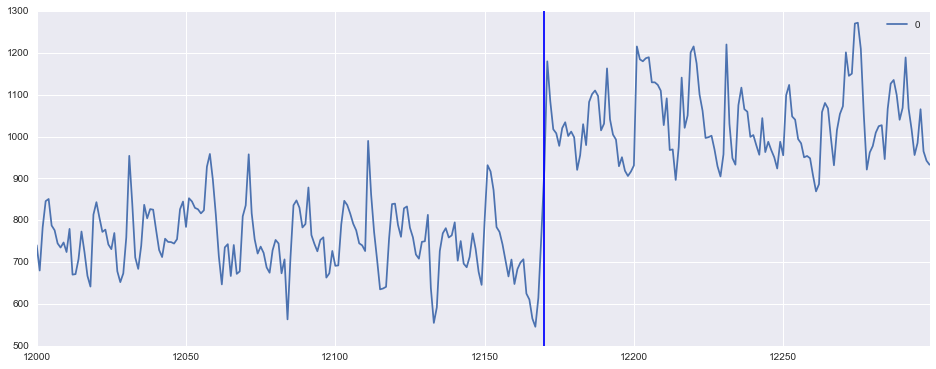

In [11]:
sync = 12170
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df_r1000[12000:12300].plot(ax=ax)
sns.plt.axvline(sync)


Грузим события из лога (`adb logcat -d |egrep "DownloadTracking|onTorchStatusChanged"`):

In [13]:
from datetime import datetime
with open("browser_download_lte_events.log") as eventlog:
    events = [
        datetime.strptime(
            l.split()[1], "%H:%M:%S.%f")
        for l in eventlog.readlines()]
offsets = [(ev - events[0]).total_seconds() for ev in events]

И построим их на нашем графике:

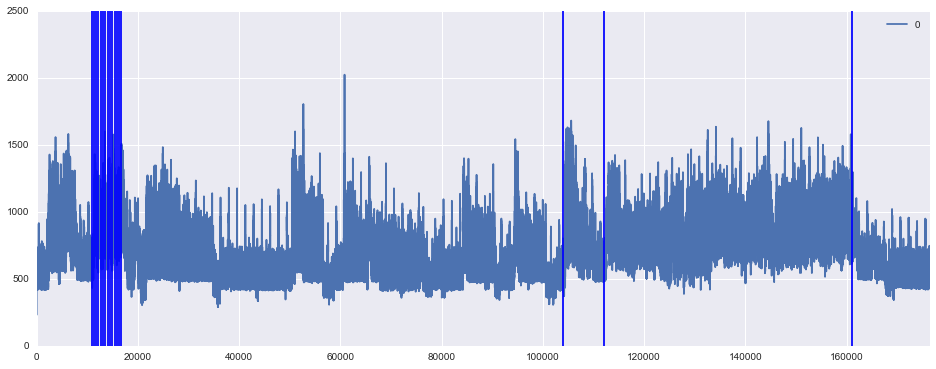

In [15]:
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df_r1000.plot(ax=ax)

for o in offsets:
    sns.plt.axvline(sync + (o - offsets[3]) * 1000)


Seems like ok. Нас интересует первый стабильный период в районе 20000 - 80000 (хотя, по-видимому, там что-то тоже происходило) и период скачивания -- последние две метки.

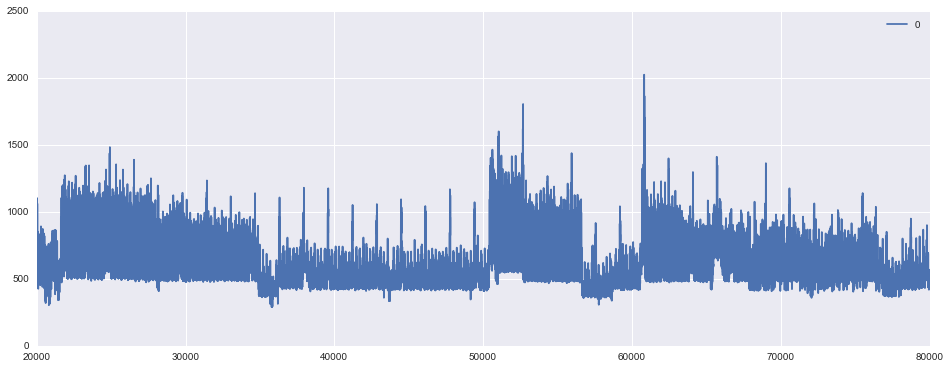

In [25]:
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df_r1000[20000:80000].plot(ax=ax)

for o in offsets:
    sns.plt.axvline(sync + (o - offsets[7]) * 1000)

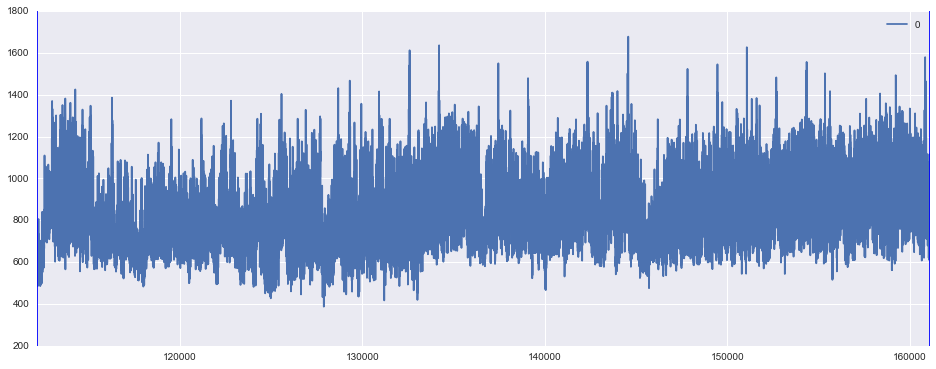

In [26]:
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df_r1000[
    int(sync + (offsets[-2] - offsets[3]) * 1000):int(
        sync + (offsets[-1] - offsets[3]) * 1000)].plot(ax=ax)

for o in offsets:
    sns.plt.axvline(sync + (o - offsets[3]) * 1000)

Сравниваем средние:

In [27]:
curr_mean_idle = df_r1000[20000:80000].mean()
curr_mean_download = df_r1000[
    int(sync + (offsets[-2] - offsets[3]) * 1000):int(
        sync + (offsets[-1] - offsets[3]) * 1000)].mean()
print("Среднее значение тока в покое, мА: %.2f" % curr_mean_idle)
print("Среднее значение тока во время загрузки, мА: %.2f" % curr_mean_download)
print("Разница, мА: %.2f" % (curr_mean_download - curr_mean_idle))

Среднее значение тока в покое, мА: 567.97
Среднее значение тока во время загрузки, мА: 791.80
Разница, мА: 223.83
